In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD

##############################################
# Parameters & Setup
##############################################
seq_len = 10
embedding_dim = 8
batch_size = 64
data_dir = 'split_data_parquet'

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]

# Identify shard files
train_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

##############################################
# Build Player ID Mapping
##############################################
def gather_unique_player_ids(files, player_cols):
    unique_ids = set()
    for fpath in files:
        print(f"Scanning file for unique IDs: {fpath}")
        df = pd.read_parquet(fpath, columns=player_cols)  # load only player columns
        df = df.dropna(subset=player_cols)
        for col in player_cols:
            unique_ids.update(df[col].dropna().astype(int).unique())
    return unique_ids

all_files = train_files + val_files + test_files
all_unique_ids = gather_unique_player_ids(all_files, player_columns)

unique_players = np.sort(list(all_unique_ids))
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example mapping:", list(player_to_index.items())[:10])

##############################################
# Model Definition Using Embeddings (with updated v)
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

offense_emb = layers.Lambda(lambda t: t[:, :5, :], name='offense_slice')(player_embedding)
defense_emb = layers.Lambda(lambda t: t[:, 5:, :], name='defense_slice')(player_embedding)

off_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='off_mean')(offense_emb)
def_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='def_mean')(defense_emb)

concat = layers.Concatenate(name='concat')([off_mean, def_mean])
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

# Set a custom learning rate
# optimizer = Adam(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.01, momentum=0.9)

model = Model(inputs=input_players, outputs=[main_out, second_chance_out])
model.compile(
    optimizer=optimizer,
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

##############################################
# Utility Functions for tf.data Pipeline
##############################################
def shard_generator(file_list, main_col, sc_col, mapping):
    """
    Yields individual samples (X, (y_main, y_sc)) from shard files.
    Applies player_to_index mapping to ensure IDs are in [0, v-1].
    """
    for fpath in file_list:
        print(f"Loading shard: {fpath}")
        df = pd.read_parquet(fpath)

        # Drop rows with NaNs in player columns
        df = df.dropna(subset=player_columns)

        # Convert players to int
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        # Drop unwanted columns
        for c in unwanted_cols:
            if c in df.columns:
                df.drop(columns=c, inplace=True)

        # One-hot the outcome column
        categories = sorted(df[main_col].unique())
        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        num_samples = len(df)
        y_main = np.zeros((num_samples, 14), dtype='float32')
        for i, val in enumerate(df[main_col]):
            class_idx = cat_to_idx[val]
            y_main[i, class_idx] = 1.0

        y_sc = df[sc_col].astype(int).values.reshape(-1, 1)

        # Drop target columns now
        df.drop(columns=[main_col, sc_col], inplace=True)

        # Map player IDs
        for c in player_columns:
            df[c] = df[c].map(mapping)

        X = df[player_columns].values.astype(np.int32)

        # Yield each sample
        for i in range(num_samples):
            yield X[i], (y_main[i], y_sc[i])

def create_dataset(file_list, main_col, sc_col, batch_size, mapping, shuffle_buffer=10000):
    ds = tf.data.Dataset.from_generator(
        lambda: shard_generator(file_list, main_col, sc_col, mapping),
        output_types=(tf.int32, (tf.float32, tf.float32)),
        output_shapes=((seq_len,), ((14,), (1,)))
    )

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

##############################################
# Create Datasets using mapping
##############################################
train_ds = create_dataset(train_files, main_out_column, second_chance_column, batch_size, player_to_index)
val_ds = create_dataset(val_files, main_out_column, second_chance_column, batch_size, player_to_index)
test_ds = create_dataset(test_files, main_out_column, second_chance_column, batch_size, player_to_index)

##############################################
# Training with tf.data
##############################################
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

##############################################
# Evaluation
##############################################
model.evaluate(test_ds)

Scanning file for unique IDs: split_data_parquet/train_000.parquet
Scanning file for unique IDs: split_data_parquet/train_001.parquet
Scanning file for unique IDs: split_data_parquet/train_002.parquet
Scanning file for unique IDs: split_data_parquet/train_003.parquet
Scanning file for unique IDs: split_data_parquet/train_004.parquet
Scanning file for unique IDs: split_data_parquet/train_005.parquet
Scanning file for unique IDs: split_data_parquet/train_006.parquet
Scanning file for unique IDs: split_data_parquet/train_007.parquet
Scanning file for unique IDs: split_data_parquet/train_008.parquet
Scanning file for unique IDs: split_data_parquet/train_009.parquet
Scanning file for unique IDs: split_data_parquet/val_000.parquet
Scanning file for unique IDs: split_data_parquet/val_001.parquet
Scanning file for unique IDs: split_data_parquet/test_000.parquet
Scanning file for unique IDs: split_data_parquet/test_001.parquet
Number of unique players: 1721
Example mapping: [(708, 0), (977, 1),

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 16)    │     27,536 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 16)     │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 16)     │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 16)        │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 16)        │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 32)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      4,224 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,695 (131.62 KB)

 Trainable params: 33,695 (131.62 KB)

 Non-trainable params: 0 (0.00 B)

Loading shard: split_data_parquet/train_000.parquet
   4271/Unknown 16s 4ms/step - loss: 2.4739 - main_out_accuracy: 0.3503 - main_out_loss: 2.1169 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3570Loading shard: split_data_parquet/train_001.parquet
   8718/Unknown 32s 4ms/step - loss: 2.4586 - main_out_accuracy: 0.3515 - main_out_loss: 2.1052 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3534Loading shard: split_data_parquet/train_002.parquet
  13154/Unknown 47s 4ms/step - loss: 2.4526 - main_out_accuracy: 0.3521 - main_out_loss: 2.1004 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3522Loading shard: split_data_parquet/train_003.parquet
  17594/Unknown 63s 4ms/step - loss: 2.4490 - main_out_accuracy: 0.3524 - main_out_loss: 2.0975 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3515Loading shard: split_data_parquet/train_004.parquet
  22047/Unknown 79s 4ms/step - loss: 2.4466 - main_out_accuracy: 0.3526 - main_o

2024-12-09 21:58:08.384399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
44410/44410 ━━━━━━━━━━━━━━━━━━━━ 176s 4ms/step - loss: 2.4399 - main_out_accuracy: 0.3530 - main_out_loss: 2.0899 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3500 - val_loss: 2.4230 - val_main_out_accuracy: 0.3538 - val_main_out_loss: 2.0730 - val_second_chance_out_accuracy: 0.8883 - val_second_chance_out_loss: 0.3496


2024-12-09 21:58:26.584036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/test_000.parquet
   2608/Unknown 9s 3ms/step - loss: 2.4197 - main_out_accuracy: 0.3530 - main_out_loss: 2.0747 - second_chance_out_accuracy: 0.8906 - second_chance_out_loss: 0.3449Loading shard: split_data_parquet/test_001.parquet
5552/5552 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.4224 - main_out_accuracy: 0.3533 - main_out_loss: 2.0752 - second_chance_out_accuracy: 0.8895 - second_chance_out_loss: 0.3472


2024-12-09 21:58:45.428416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[2.4235146045684814,
 2.0739688873291016,
 0.34910041093826294,
 0.35386738181114197,
 0.8885385990142822]

In [3]:
import pandas as pd

# After training the model and having player_to_index, unique_players defined:
embedding_matrix = model.get_layer('player_embedding').get_weights()[0]

# Create a DataFrame for player embeddings
# Columns: ['player_id', 'embed_0', 'embed_1', ..., 'embed_{embedding_dim-1}']
columns = ['player_id'] + [f'embed_{d}' for d in range(embedding_matrix.shape[1])]

data = []
for p, i in player_to_index.items():
    # embedding_matrix[i] is the embedding vector for player p
    row = [p] + embedding_matrix[i].tolist()
    data.append(row)

df = pd.DataFrame(data, columns=columns)

# Save to a CSV file
output_csv = 'player_embeddings.csv'
df.to_csv(output_csv, index=False)

print(f"Saved player embeddings to {output_csv}")

Saved player embeddings to player_embeddings.csv


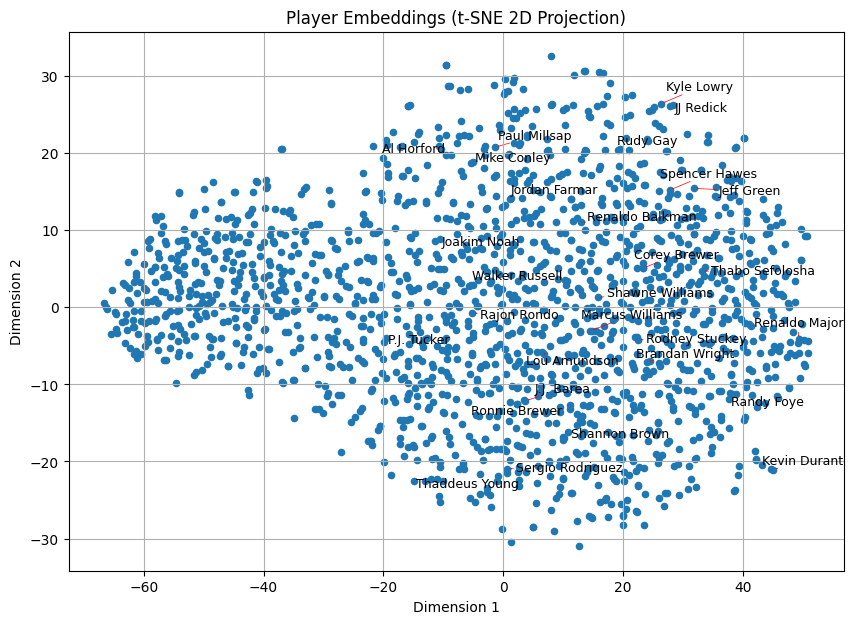

In [4]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nba_api.stats.static import players
from adjustText import adjust_text

# Load the embeddings from the CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the CSV path is correct

player_ids = df['player_id'].values
# Extract embedding columns (all except 'player_id')
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Run TSNE on vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(vectors)

x_coords = tsne_coords[:, 0]
y_coords = tsne_coords[:, 1]

# Get NBA players list and create a dict id->full_name if your player_id matches nba_api ids
all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

plt.figure(figsize=(10, 7))
plt.scatter(x_coords, y_coords, s=20)

# We'll store text objects separately and then call adjust_text
texts = []

# Label the first 10 points (or any other selection logic)
for i, pid in enumerate(player_ids):
    if 100 < i < 130:
        label = id_to_name.get(pid, str(pid))
        # Instead of plt.text directly, we add them to a list
        text_obj = plt.text(x_coords[i], y_coords[i], label, fontsize=9)
        texts.append(text_obj)

plt.title("Player Embeddings (t-SNE 2D Projection)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)

# Adjust text positions to avoid overlap
adjust_text(texts, x=x_coords[:10], y=y_coords[:10], arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.show()

In [6]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure correct path
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# LeBron James player_id in nba_api:
lebron_id = 2544
if lebron_id not in id_to_index:
    raise ValueError("LeBron James (player_id=2544) not found in embeddings CSV.")

lebron_idx = id_to_index[lebron_id]
lebron_vec = vectors[lebron_idx].reshape(1, -1)

# Compute cosine similarity between LeBron and all other players
similarities = cosine_similarity(lebron_vec, vectors)[0]  # shape (num_players,)

# Set LeBron's own similarity to -inf
similarities[lebron_idx] = -np.inf

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]  # descending order
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to LeBron James:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to LeBron James:
1. Austin Reaves (ID: 1630559), similarity: 0.7731
2. DeAndre Jordan (ID: 201599), similarity: 0.7149
3. Karl-Anthony Towns (ID: 1626157), similarity: 0.7073
4. Nicolas Batum (ID: 201587), similarity: 0.7007
5. Tyrese Maxey (ID: 1630178), similarity: 0.6882
6. Monté Morris (ID: 1628420), similarity: 0.6830
7. Kevin Love (ID: 201567), similarity: 0.6806
8. D'Angelo Russell (ID: 1626156), similarity: 0.6724
9. Anthony Davis (ID: 203076), similarity: 0.6705
10. 203472 (ID: 203472), similarity: 0.6639
11. Jonathan Isaac (ID: 1628371), similarity: 0.6606
12. Nikola Jokić (ID: 203999), similarity: 0.6575
13. Frank Kaminsky (ID: 1626163), similarity: 0.6546
14. Chris Paul (ID: 101108), similarity: 0.6484
15. Tre Jones (ID: 1630200), similarity: 0.6308
16. Aaron Gordon (ID: 203932), similarity: 0.6293
17. Nick Smith Jr. (ID: 1641733), similarity: 0.6220
18. Herbert Jones (ID: 1630529), similarity: 0.6137
19. James Harden (ID: 201935), similarity: 0.6132
2

In [7]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure correct path
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Stephen Curry player_id in nba_api:
curry_id = 201939
if curry_id not in id_to_index:
    raise ValueError("Stephen Curry (player_id=201939) not found in embeddings CSV.")

curry_idx = id_to_index[curry_id]
curry_vec = vectors[curry_idx].reshape(1, -1)

# Compute cosine similarity between Curry and all other players
similarities = cosine_similarity(curry_vec, vectors)[0]  # shape (num_players,)

# Set Curry's own similarity to -inf so he doesn't appear as his own closest match
similarities[curry_idx] = -np.inf

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]  # descending order
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Stephen Curry:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Stephen Curry:
1. Draymond Green (ID: 203110), similarity: 0.8382
2. GG Jackson (ID: 1641713), similarity: 0.8318
3. Klay Thompson (ID: 202691), similarity: 0.8186
4. Jamal Murray (ID: 1627750), similarity: 0.7687
5. Kevon Looney (ID: 1626172), similarity: 0.7500
6. Chris Paul (ID: 101108), similarity: 0.7475
7. Max Strus (ID: 1629622), similarity: 0.7458
8. Corey Kispert (ID: 1630557), similarity: 0.7430
9. Jaden McDaniels (ID: 1630183), similarity: 0.7246
10. Georges Niang (ID: 1627777), similarity: 0.7220
11. Mikal Bridges (ID: 1628969), similarity: 0.6654
12. Mike Scott (ID: 203118), similarity: 0.6594
13. Shawn Marion (ID: 1890), similarity: 0.6585
14. Jae Crowder (ID: 203109), similarity: 0.6578
15. 1628460 (ID: 1628460), similarity: 0.6543
16. Andre Iguodala (ID: 2738), similarity: 0.6541
17. Taurean Prince (ID: 1627752), similarity: 0.6527
18. JJ Redick (ID: 200755), similarity: 0.6473
19. Kelly Olynyk (ID: 203482), similarity: 0.6447
20. Jose Alvarado 

In [42]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Jayson Tatum's player_id in nba_api:
tatum_id = 1628369
if tatum_id not in id_to_index:
    raise ValueError("Jayson Tatum (player_id=1628369) not found in embeddings CSV.")

tatum_idx = id_to_index[tatum_id]
tatum_vec = vectors[tatum_idx].reshape(1, -1)

# Compute cosine similarity between Tatum and all other players
similarities = cosine_similarity(tatum_vec, vectors)[0]  # shape (num_players,)

# Set Tatum's own similarity to -inf so he doesn't appear as his own closest match
similarities[tatum_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Jayson Tatum:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Jayson Tatum:
1. Giannis Antetokounmpo (ID: 203507), similarity: 0.8967
2. Norman Powell (ID: 1626181), similarity: 0.8879
3. Kris Dunn (ID: 1627739), similarity: 0.8860
4. Duncan Robinson (ID: 1629130), similarity: 0.8820
5. Paul George (ID: 202331), similarity: 0.8784
6. Oshae Brissett (ID: 1629052), similarity: 0.8671
7. Josh Green (ID: 1630182), similarity: 0.8661
8. Chimezie Metu (ID: 1629002), similarity: 0.8596
9. Jordan Clarkson (ID: 203903), similarity: 0.8581
10. LaMelo Ball (ID: 1630163), similarity: 0.8516
11. CJ McCollum (ID: 203468), similarity: 0.8500
12. Jevon Carter (ID: 1628975), similarity: 0.8489
13. Jake LaRavia (ID: 1631222), similarity: 0.8450
14. Kyle Anderson (ID: 203937), similarity: 0.8422
15. Malcolm Brogdon (ID: 1627763), similarity: 0.8410
16. Haywood Highsmith (ID: 1629312), similarity: 0.8394
17. Jalen McDaniels (ID: 1629667), similarity: 0.8376
18. Michael Porter Jr. (ID: 1629008), similarity: 0.8335
19. Gary Harris (ID: 203914)

In [43]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Jaylen Brown's player_id in nba_api:
brown_id = 1627759
if brown_id not in id_to_index:
    raise ValueError("Jaylen Brown (player_id=1627759) not found in embeddings CSV.")

brown_idx = id_to_index[brown_id]
brown_vec = vectors[brown_idx].reshape(1, -1)

# Compute cosine similarity between Brown and all other players
similarities = cosine_similarity(brown_vec, vectors)[0]  # shape (num_players,)

# Set Brown's own similarity to -inf so he doesn't appear as his own closest match
similarities[brown_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Jaylen Brown:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Jaylen Brown:
1. Derrick White (ID: 1628401), similarity: 0.9244
2. Grayson Allen (ID: 1628960), similarity: 0.9067
3. Ja Morant (ID: 1629630), similarity: 0.8747
4. Lonnie Walker IV (ID: 1629022), similarity: 0.8737
5. LaMelo Ball (ID: 1630163), similarity: 0.8631
6. Malik Beasley (ID: 1627736), similarity: 0.8605
7. Josh Okogie (ID: 1629006), similarity: 0.8502
8. Kevin Durant (ID: 201142), similarity: 0.8465
9. Stephen Curry (ID: 201939), similarity: 0.8434
10. Russell Westbrook (ID: 201566), similarity: 0.8335
11. Ayo Dosunmu (ID: 1630245), similarity: 0.8305
12. Jimmy Butler (ID: 202710), similarity: 0.8239
13. Killian Hayes (ID: 1630165), similarity: 0.8214
14. Damian Lillard (ID: 203081), similarity: 0.8200
15. Christian Wood (ID: 1626174), similarity: 0.8190
16. Giannis Antetokounmpo (ID: 203507), similarity: 0.8168
17. Cason Wallace (ID: 1641717), similarity: 0.8165
18. Joel Embiid (ID: 203954), similarity: 0.8152
19. Santi Aldama (ID: 1630583), simila

In [44]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Rudy Gobert's player_id in nba_api:
gobert_id = 203497
if gobert_id not in id_to_index:
    raise ValueError("Rudy Gobert (player_id=203497) not found in embeddings CSV.")

gobert_idx = id_to_index[gobert_id]
gobert_vec = vectors[gobert_idx].reshape(1, -1)

# Compute cosine similarity between Gobert and all other players
similarities = cosine_similarity(gobert_vec, vectors)[0]  # shape (num_players,)

# Set Gobert's own similarity to -inf so he doesn't appear as his own closest match
similarities[gobert_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Rudy Gobert:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Rudy Gobert:
1. Devonte' Graham (ID: 1628984), similarity: 0.9542
2. Justin Holiday (ID: 203200), similarity: 0.9367
3. Matisse Thybulle (ID: 1629680), similarity: 0.9205
4. Tyrese Haliburton (ID: 1630169), similarity: 0.9181
5. Nickeil Alexander-Walker (ID: 1629638), similarity: 0.9118
6. Marcus Sasser (ID: 1631204), similarity: 0.8981
7. Cedi Osman (ID: 1626224), similarity: 0.8937
8. KJ Martin (ID: 1630231), similarity: 0.8878
9. Joe Ingles (ID: 204060), similarity: 0.8793
10. Bruce Brown (ID: 1628971), similarity: 0.8737
11. Jaden Hardy (ID: 1630702), similarity: 0.8732
12. Alex Caruso (ID: 1627936), similarity: 0.8706
13. Jaden Ivey (ID: 1631093), similarity: 0.8692
14. DeAndre Jordan (ID: 201599), similarity: 0.8591
15. Jeff Green (ID: 201145), similarity: 0.8548
16. Ausar Thompson (ID: 1641709), similarity: 0.8523
17. Jordan Goodwin (ID: 1630692), similarity: 0.8471
18. Saddiq Bey (ID: 1630180), similarity: 0.8397
19. Eric Gordon (ID: 201569), similarity